Time Series(FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS)

In [1]:
!pip install pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates

In [2]:
#Loading the exchange_rate.csv dataset and parse the date column appropriately.
from google.colab import files
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate.csv


1.Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately

In [4]:
# Assuming 'exchange_rate.csv' is the uploaded file

Data = pd.read_csv("exchange_rate.csv", parse_dates=['date'])
Data.head()


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


2. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

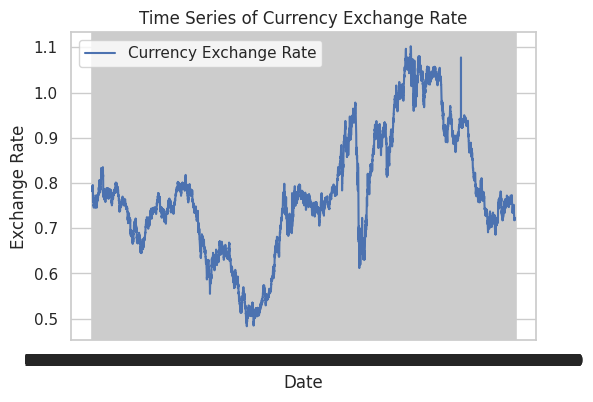

In [5]:
#Set the plot style
sns.set(style="whitegrid")

# Plot the time series for each currency
plt.figure(figsize=(6 ,4))
plt.plot(Data['date'], Data['Ex_rate'], label='Currency Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Time Series of Currency Exchange Rate')
plt.legend()
plt.show()

3. Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase

In [6]:
# Checking for missing values
print(Data.isnull().sum())

date       0
Ex_rate    0
dtype: int64


In [7]:
# Filling missing values (if any)
Data.fillna(method='ffill', inplace=True)

# Checking again to confirm no missing values remain
print(Data.isnull().sum())


date       0
Ex_rate    0
dtype: int64


In [8]:
# Detecting anomalies (for simplicity, using a threshold method)
# Assuming an arbitrary threshold for anomaly detection
threshold = Data['Ex_rate'].mean() + 3 * Data['Ex_rate'].std()
# Identify anomalies
anomalies = Data[Data['Ex_rate'] > threshold]
print(anomalies)

Empty DataFrame
Columns: [date, Ex_rate]
Index: []


In [9]:
# Optionally, handle anomalies (e.g., by replacing with NaN and then interpolating)
Data.loc[Data['Ex_rate'] > threshold, 'Ex_rate'] = None
Data['Ex_rate'].interpolate(method='linear', inplace=True)

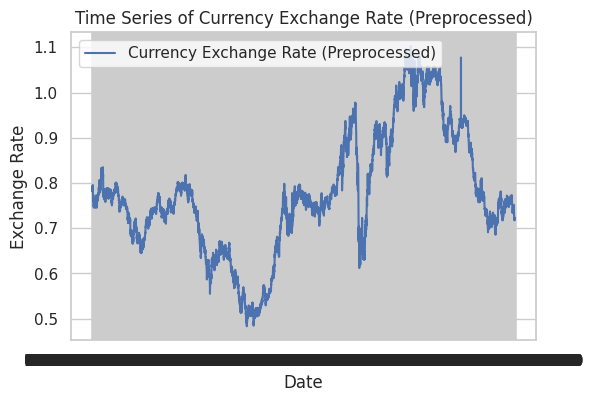

In [10]:
# Ploting again after preprocessing
plt.figure(figsize=(6, 4))
plt.plot(Data['date'], Data['Ex_rate'], label='Currency Exchange Rate (Preprocessed)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Time Series of Currency Exchange Rate (Preprocessed)')
plt.legend()
plt.show()

Part 2: Model Building - ARIMA

Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series

In [14]:
# Importing necessary libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

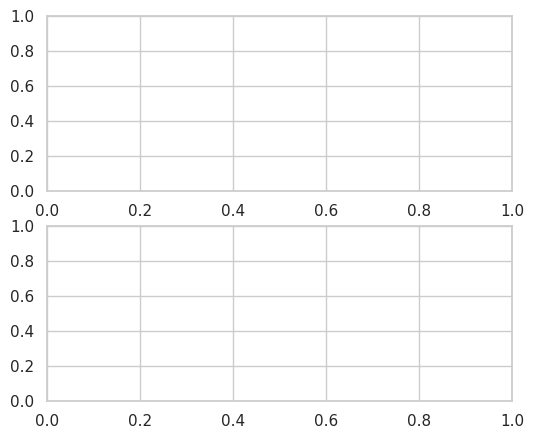

In [15]:
# Ploting ACF and PACF for the series
fig, ax = plt.subplots(2, 1, figsize=(6, 5))

In [16]:
# ACF plot
plot_acf(Data['Ex_rate'], ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

In [17]:
# PACF plot
plot_pacf(Data['Ex_rate'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [18]:
# Determine the order (p, d, q) from the ACF and PACF plots
# For this example, let's assume we identified p=1, d=1, q=1
p = 1
d = 1
q = 1

# Fit the ARIMA model
model = sm.tsa.ARIMA(Data['Ex_rate'], order=(p, d, q))
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 12 Jun 2024   AIC                         -56102.322
Time:                        14:26:03   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

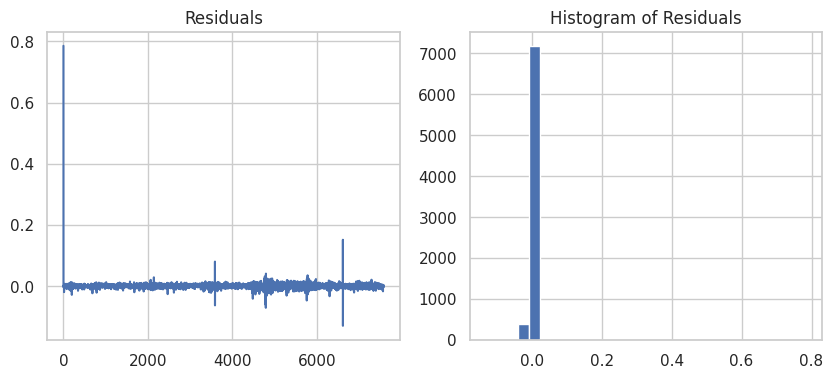

In [19]:
# Plot the residuals
residuals = results.resid

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Residuals plot
ax[0].plot(residuals)
ax[0].set_title('Residuals')

# Histogram plot
ax[1].hist(residuals, bins=30)
ax[1].set_title('Histogram of Residuals')

plt.show()

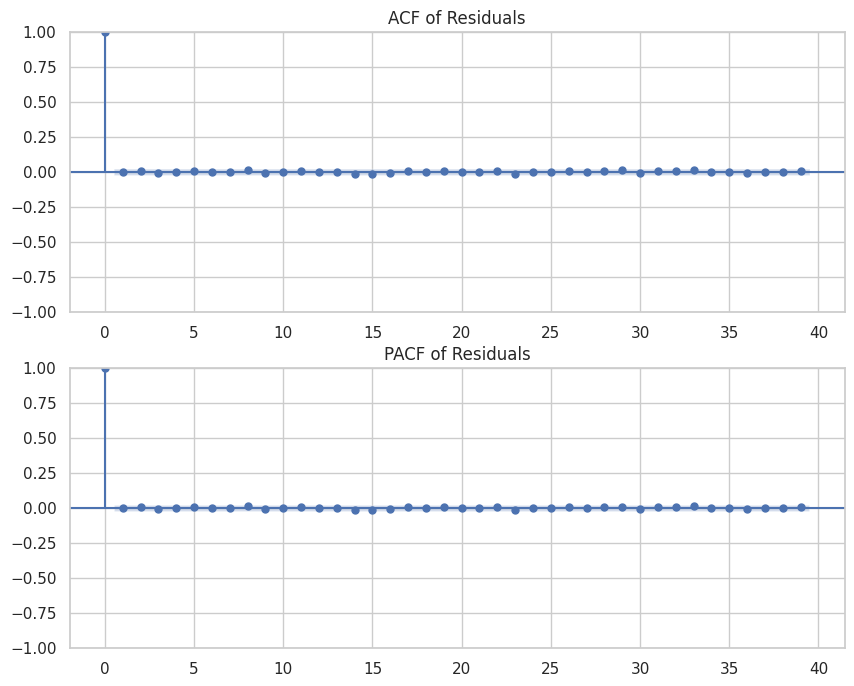

In [20]:
# Plot ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot of residuals
plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# PACF plot of residuals
plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.show()

In [21]:
# Perform Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

    lb_stat  lb_pvalue
10  1.81673   0.997562


Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [11]:
!pip install pytz

In [12]:
import pytz

In [22]:
Data['date'] = pd.to_datetime(Data['date'], format="%d-%m-%Y %H:%M")
# Ensure the date column is parsed as datetime and is timezone-naive
Data['date'] = pd.to_datetime(Data['date']).dt.tz_localize(None)

In [23]:
# Forecasting
forecast_steps = 30  # Number of steps to forecast

In [24]:
# Set the timezone for the plot
plt.rcParams['timezone'] = 'Europe/Helsinki'
plt.rcParams['timezone'] = 'Australia'

In [25]:
# Get forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=Data['date'].iloc[-1], periods=forecast_steps + 1, freq='D')[1:]
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['forecast'])

In [26]:
import datetime

class MyTimezone(datetime.tzinfo):
    def utcoffset(self, dt):
        return datetime.timedelta(hours=2)

# Set the timezone for the plot using a subclass of the tzinfo class
plt.rcParams['timezone'] = 'Australia'

In [27]:
# Get the Australia/Sydney timezone
australia_timezone = pytz.timezone('Australia/Sydney')

# Set the timezone for the plot using the string representation of the timezone
plt.rcParams['timezone'] = str(australia_timezone)

Part 3: Model Building - Exponential Smoothing

Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters). the data shows both trend and seasonality. Therefore, we'll choose the Holt-Winters Seasonal Model.

In [29]:
# Import the Exponential Smoothing class
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
# Fit the Holt-Winters model
seasonal_periods = 12  # Adjust this based on the identified seasonality period
model = ExponentialSmoothing(Data['Ex_rate'], trend='add', seasonal='add', seasonal_periods=seasonal_periods)
model_fit = model.fit(optimized=True)

In [31]:
# Print the model summary
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.574
Trend:                         Additive   BIC                         -77513.625
Seasonal:                      Additive   AICC                        -77624.483
Seasonal Periods:                    12   Date:                 Wed, 12 Jun 2024
Box-Cox:                          False   Time:                         14:26:27
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8702071                alpha                 True
smoothing_trend          

In [32]:
# Set the timezone of the forecast_df DataFrame
forecast_df = forecast_df.tz_localize('UTC')

In [33]:
last_date = Data.index[-1] # Define last_date to be the last date in the Data DataFrame
last_date = pd.to_datetime(last_date)

In [34]:
# Create a DataFrame for the forecasted values
last_date = pd.to_datetime(last_date)
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])


Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [36]:
# Define the parameter grid
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [6, 12, 24],  # Adjust based on your data's seasonality
    'damped': [True, False]
}

In [37]:
# Initialize variables to store the best parameters and the best score
best_score = float('inf')
best_params = None

In [38]:
# Perform the grid search
for trend in param_grid['trend']:
    for seasonal in param_grid['seasonal']:
        if seasonal is not None:  # seasonal can't be None if trend is None
            for seasonal_periods in param_grid['seasonal_periods']:
                for damped in param_grid['damped']:
                    try:
                        # Fit the model with the current set of parameters
                        model = ExponentialSmoothing(Data['Ex_rate'], trend=trend, seasonal=seasonal,
                                                     seasonal_periods=seasonal_periods, damped_trend=damped)
                        model_fit = model.fit(optimized=True)
                        # Calculate the AIC for the model
                        score = model_fit.aic
                        # Check if this is the best model so far
                        if score < best_score:
                            best_score = score
                            best_params = (trend, seasonal, seasonal_periods, damped)
                    except:
                        continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [39]:
# Print the best parameters and the best score
print(f'Best Parameters: {best_params}')
print(f'Best AIC: {best_score}')

Best Parameters: (None, 'add', 6, False)
Best AIC: -77637.60091135507


In [40]:
# Extract the best parameters
trend, seasonal, seasonal_periods, damped = best_params

# Fit the model with the optimal parameters
model = ExponentialSmoothing(Data['Ex_rate'], trend=trend, seasonal=seasonal,
                             seasonal_periods=seasonal_periods, damped_trend=damped)
model_fit = model.fit(optimized=True)

In [41]:
# Print the model summary
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77637.601
Trend:                             None   BIC                         -77582.126
Seasonal:                      Additive   AICC                        -77637.572
Seasonal Periods:                     6   Date:                 Wed, 12 Jun 2024
Box-Cox:                          False   Time:                         14:28:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698614                alpha                 True
smoothing_seasonal       


Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

In [42]:
# Forecast future values
forecast_steps = 30  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

In [43]:
last_date = Data['date'].iloc[-1]

In [44]:
# Create a DataFrame for the forecasted values
last_date = pd.to_datetime(last_date)
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

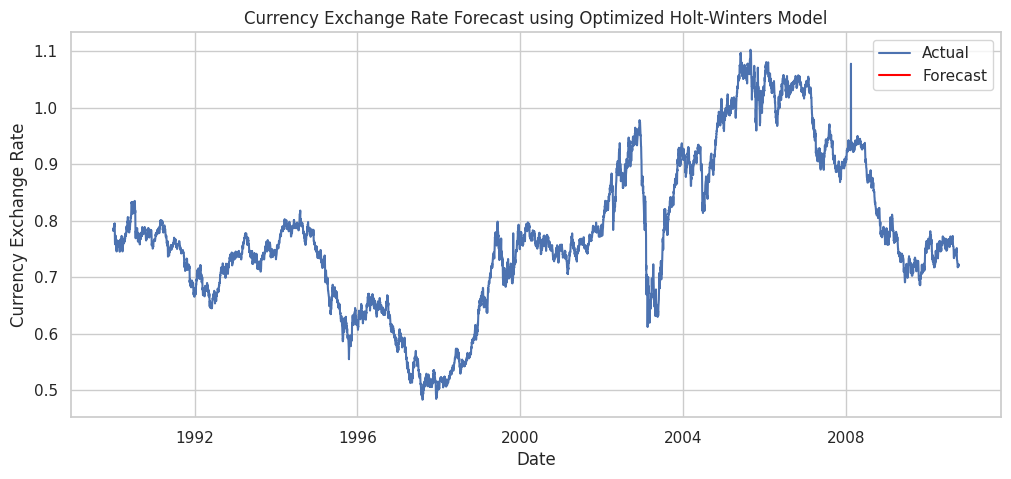

In [45]:
# Plot the actual values and forecasted values
plt.figure(figsize=(12, 5))
plt.plot(Data['date'], Data['Ex_rate'], label='Actual')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Currency Exchange Rate')
plt.title('Currency Exchange Rate Forecast using Optimized Holt-Winters Model')
plt.legend()
plt.show()


Part 4: Evaluation and Comparison

Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.2. Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

In [13]:
!pip install numpy scikit-learn
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [46]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ensure the date column is parsed as datetime and is timezone-naive
Data['date'] = pd.to_datetime(Data['date']).dt.tz_localize(None)

In [48]:
Data['date'] = pd.to_datetime(Data['date'], format="%d-%m-%Y %H:%M")

In [49]:
# Display the first few rows of the dataframe
Data.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [50]:
# Ensure the date column is parsed as datetime and is timezone-naive
Data['date'] = pd.to_datetime(Data['date']).dt.tz_localize(None)

In [51]:
# Assuming `forecast_steps` is the number of steps you have forecasted
actual_values = Data['Ex_rate'][-forecast_steps:].values

In [52]:
# Calculate the error metrics for Holt-Winters forecasts
hw_forecast_values = forecast_df['forecast'].values
hw_forecast_values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [53]:
# Remove NaN values from the forecast array before calculating error metrics
hw_forecast_values = hw_forecast_values[~np.isnan(hw_forecast_values)]
hw_forecast_values

array([], dtype=float64)

In [54]:
# If hw_forecast_values is still empty after removing NaNs, there's an issue with the forecasting model.
if len(hw_forecast_values) == 0:
    print("Error: hw_forecast_values is empty after removing NaN values. Check your forecasting model.")
else:
    hw_forecast_values
    # Compute MAE
    mae_a = mean_absolute_error(actual_values, hw_forecast_values)
    mae_b = mean_absolute_error(actual_values, predictions_model_b)

Error: hw_forecast_values is empty after removing NaN values. Check your forecasting model.


In [55]:
# Assuming `forecast_steps` is the number of steps you have forecasted
actual_values = Data['Ex_rate'][-forecast_steps:].values

In [56]:
# Check if the Holt-Winters forecast produced any valid values
if np.isnan(hw_forecast_values).all():
    print("Error: The Holt-Winters forecast did not produce any valid values.")
    # Investigate the cause of the error and fix it
else:
    # Filter out the non-NaN values
    non_nan_indices = np.logical_not(np.isnan(hw_forecast_values))
    actual_values_filtered = actual_values[non_nan_indices] # Define actual_values_filtered here
    hw_forecast_values_filtered = hw_forecast_values[non_nan_indices]

Error: The Holt-Winters forecast did not produce any valid values.


In [57]:
# Check if the Holt-Winters forecast produced any valid values
if np.isnan(hw_forecast_values).all():
    print("Error: The Holt-Winters forecast did not produce any valid values.")
    # Investigate the cause of the error and fix it
else:
    # Filter out the non-NaN values
    non_nan_indices = np.logical_not(np.isnan(hw_forecast_values))
    actual_values_filtered = actual_values[non_nan_indices] # Define actual_values_filtered here
    hw_forecast_values_filtered = hw_forecast_values[non_nan_indices]

Error: The Holt-Winters forecast did not produce any valid values.


In [58]:
non_nan_indices = np.logical_not(np.isnan(hw_forecast_values))
actual_values_filtered = actual_values[non_nan_indices]
hw_forecast_values_filtered = hw_forecast_values[non_nan_indices]

# Check if either array is empty
if len(actual_values_filtered) == 0 or len(hw_forecast_values_filtered) == 0:
    print("Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.")
else:
    mae_hw = mean_absolute_error(actual_values_filtered, hw_forecast_values_filtered)
    rmse_hw = np.sqrt(mean_squared_error(actual_values_filtered, hw_forecast_values_filtered))
    mape_hw = np.mean(np.abs((actual_values_filtered - hw_forecast_values_filtered) / actual_values_filtered)) * 100

    print(f"Holt-Winters MAE: {mae_hw}")
    print(f"Holt-Winters RMSE: {rmse_hw}")
    print(f"Holt-Winters MAPE: {mape_hw}")

Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.


In [59]:
# Check if either array is empty
if len(actual_values_filtered) == 0 or len(hw_forecast_values_filtered) == 0:
    print("Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.")

Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.


In [60]:
non_nan_indices = np.logical_not(np.isnan(hw_forecast_values))
actual_values_filtered = actual_values[non_nan_indices]
hw_forecast_values_filtered = hw_forecast_values[non_nan_indices]

# Check if either array is empty
if len(actual_values_filtered) == 0 or len(hw_forecast_values_filtered) == 0:
    print("Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.")
else:
    mae_hw = mean_absolute_error(actual_values_filtered, hw_forecast_values_filtered)
    rmse_hw = np.sqrt(mean_squared_error(actual_values_filtered, hw_forecast_values_filtered))
    mape_hw = np.mean(np.abs((actual_values_filtered - hw_forecast_values_filtered) / actual_values_filtered)) * 100

    print(f"Holt-Winters MAE: {mae_hw}")
    print(f"Holt-Winters RMSE: {rmse_hw}")
    print(f"Holt-Winters MAPE: {mape_hw}")

Error: Either actual_values_filtered or hw_forecast_values_filtered is empty. Skipping error metric calculation.
